In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import pad
from safetensors.torch import load_file

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_file_path = "../GUE_finetuned_models/DNABERT2_EMP_H3_model/model.safetensors"
loaded_state_dict = load_file(model_file_path, device=device)
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [5]:
from lrp import checkpoint_hook, lrp_engine

In [6]:
for layer_module in model.bert.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [9]:
data_path = "../GUE/EMP/H3/test.csv"
batch_size = 100
batch_start = 0
with open(data_path, "r") as fileIn:
    fileIn.readline()
    dna = []
    for _ in range(batch_start):
        fileIn.readline()
    for _ in range(batch_size):
        line = fileIn.readline()
        line = line.split(",")[0].strip()
        dna.append(line)


In [10]:
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_f

In [11]:
in_adj_list = None
out_adj_list = None
topo_exec_order = None
fcn_map = None
agg_checkpoint_vals = None

inputs = tokenizer(dna, padding=True, return_tensors = 'pt')["input_ids"]

In [12]:
inputs[0].shape

torch.Size([112])

In [13]:
# Single example test
outputs : torch.Tensor = model(inputs[0:1].to(device))
logits = outputs[0]
hidden_states = outputs.hidden_states
checkpoint_vals, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)

propagation took 1.2690002918243408 seconds
tensor(4.5401, device='cuda:0')


In [14]:
for i in range(len(inputs)):
    
    outputs : torch.Tensor = model(inputs[i:i+1].to(device))
    logits = outputs[0]
    hidden_states = outputs.hidden_states
    checkpoint_vals, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)

    if agg_checkpoint_vals is None:
        agg_checkpoint_vals = checkpoint_vals
    else:
        for j in range(len(agg_checkpoint_vals)):            
            agg_checkpoint_vals[j] += checkpoint_vals[j]


propagation took 0.6408648490905762 seconds
propagation took 0.5218884944915771 seconds
propagation took 0.5167605876922607 seconds
propagation took 0.5320887565612793 seconds
propagation took 0.5201747417449951 seconds
propagation took 0.5213308334350586 seconds
propagation took 0.5217084884643555 seconds
propagation took 0.528247594833374 seconds
propagation took 0.52813720703125 seconds
propagation took 0.5215973854064941 seconds
propagation took 0.5191655158996582 seconds
propagation took 0.5195417404174805 seconds
propagation took 0.5271475315093994 seconds
propagation took 0.5140893459320068 seconds
propagation took 0.5163400173187256 seconds
propagation took 0.5148189067840576 seconds
propagation took 0.5275893211364746 seconds
propagation took 0.5170259475708008 seconds
propagation took 0.5266194343566895 seconds
propagation took 0.5177750587463379 seconds
propagation took 0.5209553241729736 seconds
propagation took 0.5261845588684082 seconds
propagation took 0.5265491008758545

In [30]:
from add_backward_promise import AddBackwardPromise
visited = sorted(list(visited1), key=lambda x: x._sequence_nr())
visited_map = { str(node) : node for node in visited }
promises = AddBackwardPromise.all_promises

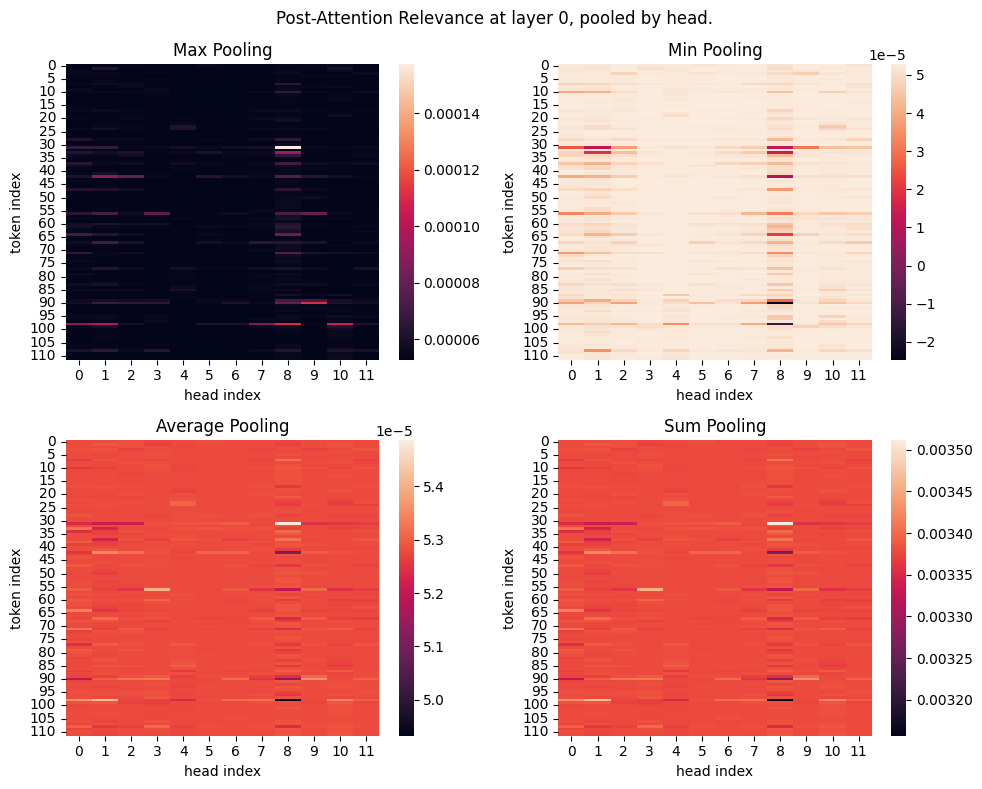

In [20]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt

# Set this to which layer you want to see
layer_ind = 0

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,8))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(torch.unsqueeze(checkpoint_vals[layer_ind], 0))
    lrp_shape = checkpoint_output.shape
    sns.heatmap(checkpoint_output.view((lrp_shape[-2], lrp_shape[-1])).cpu(), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2 - 1:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head.")
fig.tight_layout()

plt.show()